# Questão 3

Esta atividade consistiu em treinar um autoencoder já proposto na literatura e variar suas (duas) variáveis latentes em verredura para verificar o manifold encontrado e (se possível) a transição entre as classes.

Foi produzido um resultado bastante interessante quando aumentou-se o range para 30x30 imagens (foi necessário aumentar um pouco a resolução), sendo possível notar varias transições das regiões mapeadas de uma classe para outra no manifold.

Na figura ao final do código abaixo, no canto superior esquerdo, nota-se claramente o mapeamento para o dígito 3, que vai transitando para a direita até se transformar no dígito 8 (e talvez uma transição para o dígito 9, um pouco abaixo). Se pegarmos deste mesmo canto e formos descendo na imagem, é possível notar a transição para a classe 5, 6 e depois zero, nesta ordem.

Ao final de imagem vemos dígitos zeros cada vez mais definidos, pois estamos adentrando a região do manifold para este dígitos.

É claro que imagens de dígitos desenhados adequadamente não devem ter variáveis latentes nesta região do manifold, mas esta região é particularmente interessante para observarmos sua construção.

A variação das variáveis latentes dividias por 3 no loop é para que possamos ver a transição do manifold mais gradualmente.

/home/patrickctrf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/patrickctrf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


/home/patrickctrf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/patrickctrf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


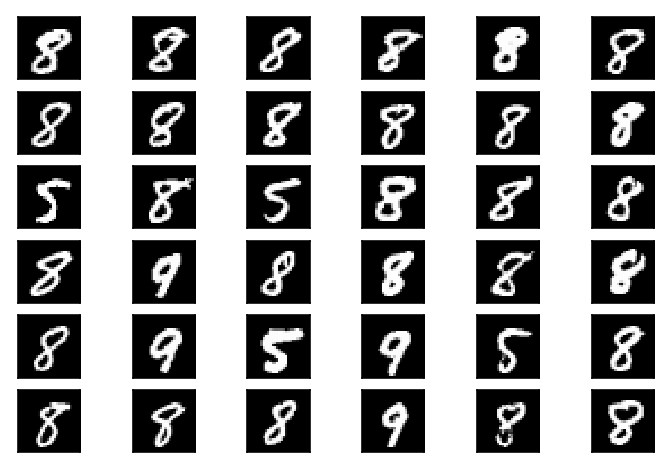

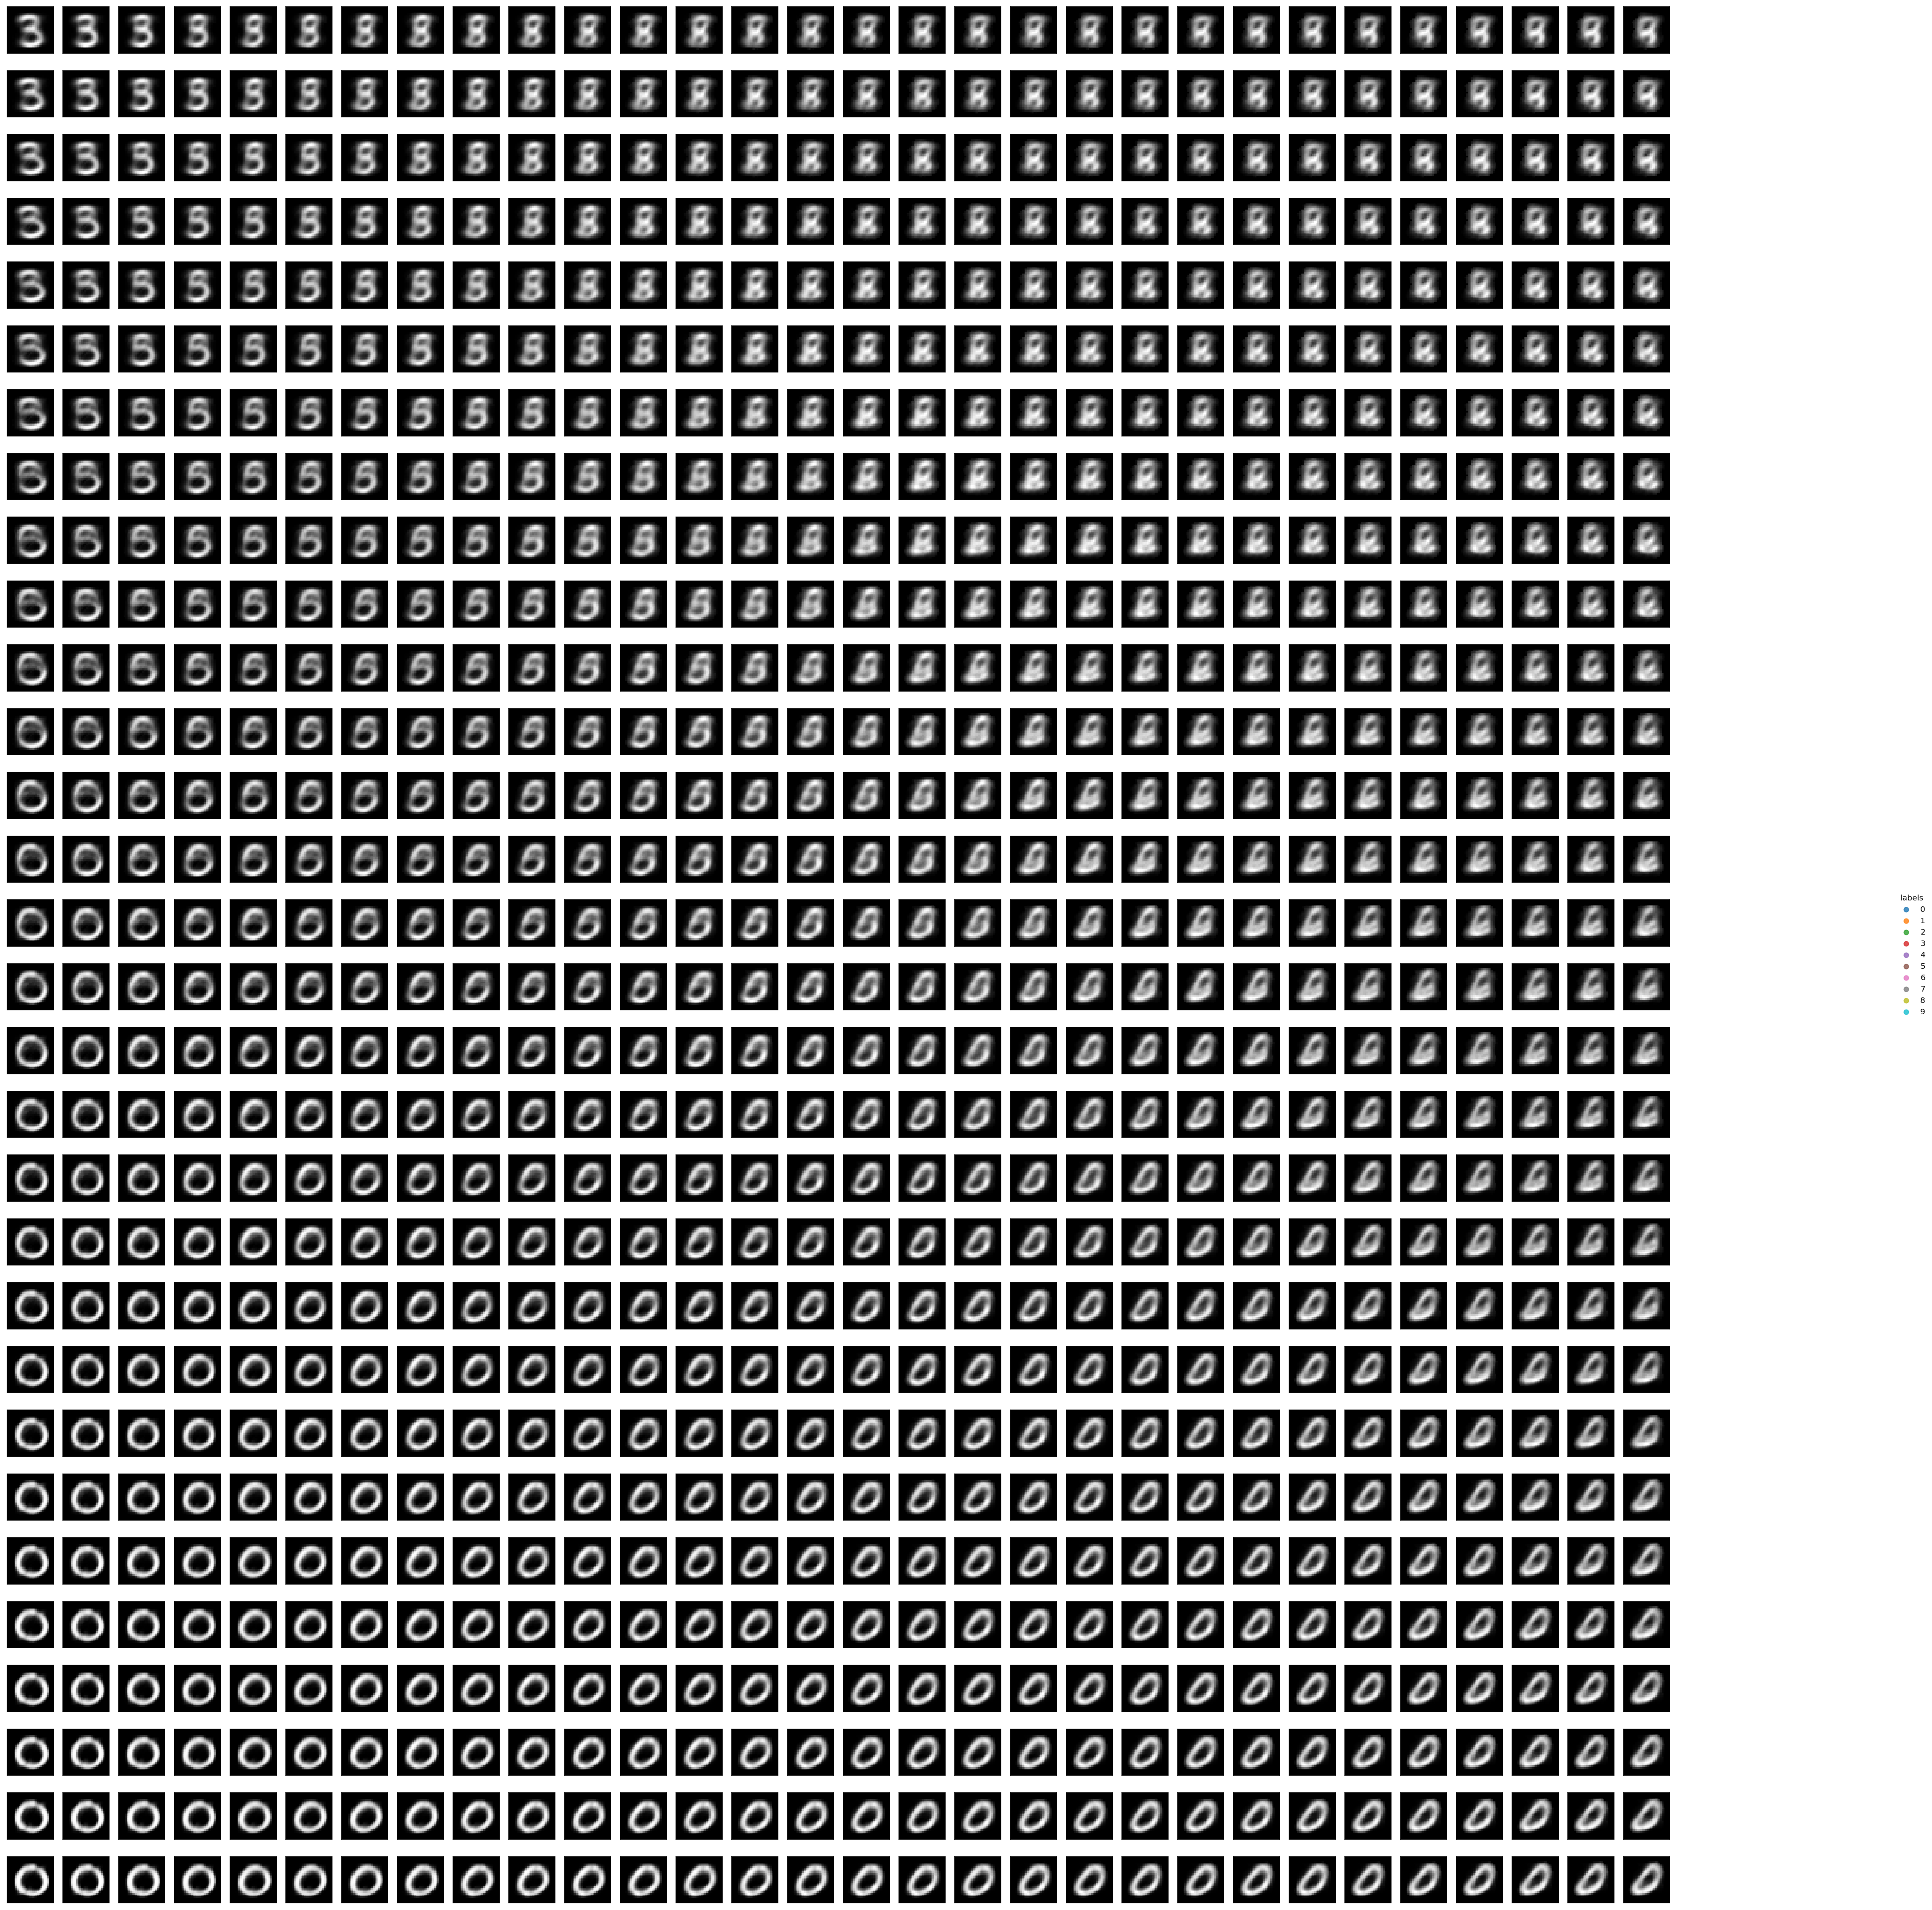

In [2]:
# Comandos para exibir imagem no jupyter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical
import matplotlib



train = pd.read_csv("../input/train.csv")

X_train = train.iloc[:,1:].values
X_train = X_train.reshape(X_train.shape[0], 28, 28) #reshape to rectangular
X_train = X_train/255 #pixel values are 0 - 255 - this makes puts them in the range 0 - 1

y_train = train["label"].values

#define a function that allows us to see the digits:
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")
    

img = X_train[10]
show(img)

pd.DataFrame(img)

#generating a random 28 by 28 image:
rand_img = np.random.randint(0, 255, (28, 28))
rand_img = rand_img/255.0

show(rand_img)

rand_direction = np.random.rand(28, 28) 


for i in range(16):
    plt.subplot(4,4,i+1)
    show(img + i/4*rand_direction)    
    plt.xticks([])
    plt.yticks([])
    
    

X_flat = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

knn = NearestNeighbors(5000)

knn.fit(X_flat[:5000])


distances, neighbors = knn.kneighbors(img.flatten().reshape(1, -1))
neighbors = neighbors[0]
distances = distances[0]

plt.hist(distances[1:])


for digit_num, num in enumerate(neighbors[:36]):
    plt.subplot(6,6,digit_num+1)
    grid_data = X_train[num]  # reshape from 1d to 2d pixel array
    show(grid_data)
    plt.xticks([])
    plt.yticks([])
    
    
    

input_img = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_img)

encoded = Dense(2)(encoded) #keep it linear here.

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)


autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.fit(X_flat, X_flat, batch_size = 128,
                nb_epoch = 10, verbose = 3)
                

encoder = Model(input = input_img, output = encoded)

#building the decoder:
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-2]
encoded_layer_2 = autoencoder.layers[-1]


decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = Model(input=encoded_input, output=decoder)


import seaborn as sns

X_proj = encoder.predict(X_flat[:10000])
X_proj.shape

proj = pd.DataFrame(X_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:10000]
sns.lmplot("comp_1", "comp_2",hue = "labels", data = proj, fit_reg=False)


#how well does the autoencoder decode:w1
plt.subplot(2,2,1)
show(X_train[160])
plt.subplot(2,2,2)
show(autoencoder.predict(np.expand_dims(X_train[160].flatten(), 0)).reshape(28, 28))
plt.subplot(2,2,3)
show(X_train[150])
plt.subplot(2,2,4)
show(autoencoder.predict(np.expand_dims(X_train[150].flatten(), 0)).reshape(28, 28))


##moving along the x axis:
#for i in range(64):
#    plt.subplot(8,8,i+1)
#    pt = np.array([[i/3,0]])
#    show(decoder.predict(pt).reshape((28, 28)))
#    plt.xticks([])
#    plt.yticks([])
#    
#    
#    
##moving along the y axis:
#for i in range(64):
#    plt.subplot(8,8,i+1)
#    pt = np.array([[10,i/3]])
#    show(decoder.predict(pt).reshape((28, 28)))
#    plt.xticks([])
#    plt.yticks([])
#    
    
#moving along both x and y axis:
for j in range(0,30):
    for i in range(0,30):
        plt.subplot(30,30,i+1+30*j)
        pt = np.array([[j/3,i/3]])
        plt.xticks([])
        plt.yticks([])
        
        # ajustando tamanho de exibição
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(40, 40)
        # fig.savefig('test2png.png', dpi=100, forward=True)
        show(decoder.predict(pt).reshape((28, 28)))
    






